In [7]:
import local_models.local_models as local_models
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.cluster
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets

np.random.seed(0)
reload(local_models)
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

In [8]:
n = 200
noisy_circles, c = sklearn.datasets.make_circles(n_samples=n, factor=.5,
                                      noise=0.01)

In [72]:
import scipy.optimize
import sklearn.utils
def quad(x2,xy,y2,x,y, A, B, C, D, E, F):
    return A*x2 + B*xy + C*y2 + D*x + E*y + F
def quad_optimizer(theta, x2, xy, y2, x, y):
    A, B, C, D, E, F, lamb, mu = theta
    quadded = quad(x2,xy,y2,x,y,A,B,C,D,E,F)
    dldA = 2*np.sum(quadded*x2) - 4*lamb*C + 2*mu*A
    dldB = 2*np.sum(quadded*xy) + 2*lamb*B + 2*mu*B
    dldC = 2*np.sum(quadded*y2) - 4*lamb*A + 2*mu*C
    dldD = 2*np.sum(quadded*x) + 2*mu*D
    dldE = 2*np.sum(quadded*y) + 2*mu*E
    dldF = 2*np.sum(quadded) + 2*mu*F
    dldlamb = B**2 - 4*A*C
    dldmu = A**2+B**2+C**2+D**2+E**2+F**2 - 1
    return dldA,dldB,dldC,dldD,dldE,dldF,dldlamb,dldmu

class QuadraticRegression(sklearn.base.RegressorMixin):
    def __init__(self):
        self.intercept_ = np.array(())
    def fit(self, X, y=None):
        X = sklearn.utils.check_array(X)
        x2 = X[:,0]**2
        xy = X[:,0]*X[:,1]
        y2 = X[:,1]**2
        x = X[:,0]
        y = X[:,1]
        blah = np.array([1]*6)
        blah = blah/np.sum(blah**2)**0.5
        self.solution = scipy.optimize.root(quad_optimizer, list(blah) + [1,1], args=(x2, xy, y2, x, y))
        self.coef_ = self.solution.x[:-2]
        return self
    def predict(self, X):
        pass
    def get_params(self, *args, **kwargs):
        return dict()
    def set_params(self, params, *args, **kwargs):
        pass

def circle_optimizer(theta, x, y):
    x0, y0, r = theta
    return np.sum(((x-x0)**2 + (y-y0)**2 - r**2)**2)
    
class CircleRegression(sklearn.base.RegressorMixin):
    def __init__(self):
        self.intercept_ = np.array(())
    def fit(self, X, y=None):
        X = sklearn.utils.check_array(X)
        x, y = X[:,0], X[:,1]
        theta0 = np.array([0]*2 + [1])
        self.solution = scipy.optimize.minimize(circle_optimizer, list(theta0), args=(x, y))
        self.coef_ = self.solution.x
        return self
    def predict(self, X):
        return np.sqrt(self.coef_[2]**2 - (X-self.coef_[0])**2) + self.coef_[1]
    def get_params(self, *args, **kwargs):
        return dict()
    def set_params(self, params, *args, **kwargs):
        pass

In [33]:
qr = QuadraticRegression()
X = np.linspace(0,1,100)
y = 2*X**2 + 3*X + 4
quadded = np.stack((X**2,X*y,y**2,X,y,np.ones(X.shape))).T
qr.fit(np.stack((X,y)).T)

In [34]:
cr = CircleRegression()
cr.fit(noisy_circles)
cr.coef_

array([-1.56385061e-03,  2.19606551e-04,  7.89823809e-01])

In [35]:
qr.coef_

array([ 3.65148372e-01, -5.74163411e-12,  8.76909218e-14,  5.47722558e-01,
       -1.82574186e-01,  7.30296743e-01,  3.25811152e-13,  1.45115104e-14])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in sqrt


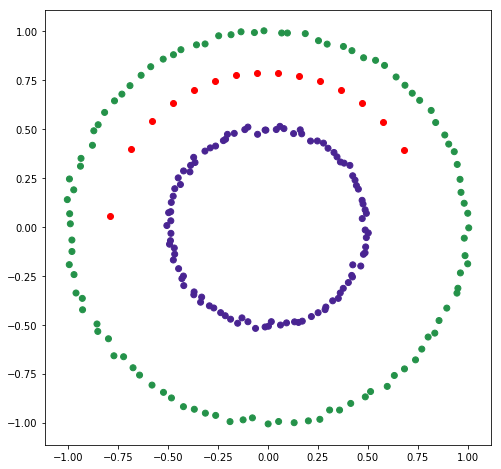

In [36]:
plt.scatter(np.linspace(-1,1,20),cr.predict(np.linspace(-1,1,20).reshape((-1,1))), c='r')
plt.scatter(noisy_circles[:,0], noisy_circles[:,1],c=cmap(c))
plt.show()

In [52]:
models = local_models.LocalModels(QuadraticRegression())
models.fit(noisy_circles)

In [53]:
lm_params = models.transform(noisy_circles,k=8)

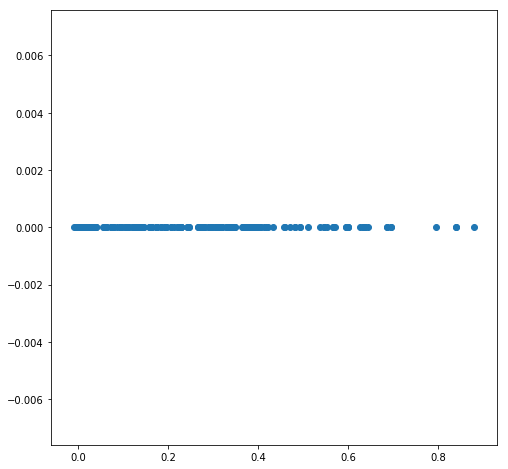

In [54]:
plt.scatter(lm_params[:,0], np.zeros(lm_params.shape[0]))
plt.show()

In [55]:
clf = sklearn.cluster.KMeans(2)

In [56]:
clf.fit(lm_params)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

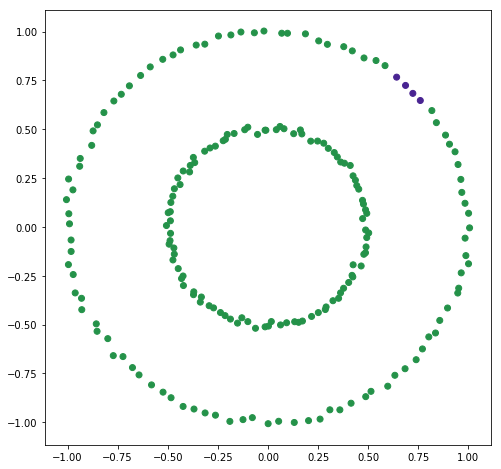

In [57]:
plt.scatter(noisy_circles[:,0], noisy_circles[:,1],c=cmap(clf.predict(lm_params)))
plt.show()

In [37]:
circle_models = local_models.LocalModels(CircleRegression())
circle_models.fit(noisy_circles)

In [38]:
circle_params = circle_models.transform(noisy_circles,k=8)

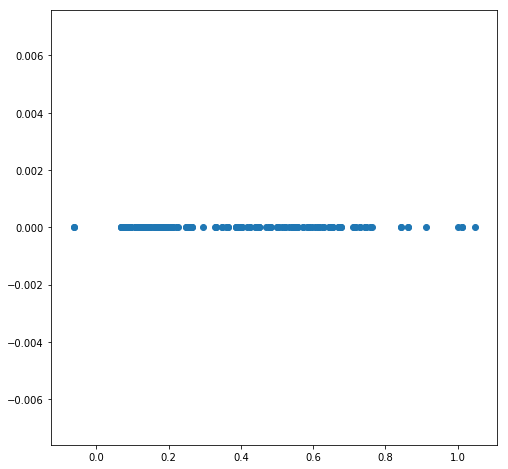

In [39]:
plt.scatter(circle_params[:,2], np.zeros(circle_params.shape[0]))
plt.show()

In [44]:
circle_km = sklearn.cluster.KMeans(2)
circle_km.fit(circle_params[:,2:])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

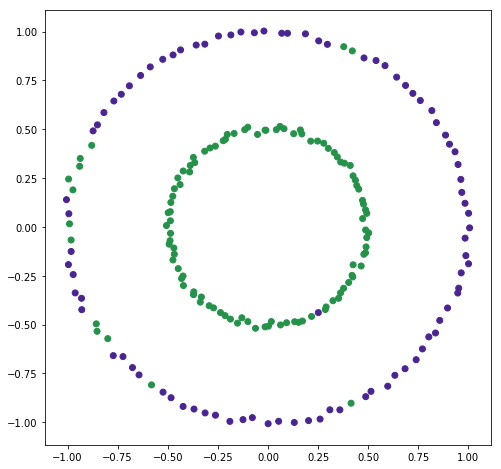

In [47]:
plt.scatter(noisy_circles[:,0], noisy_circles[:,1],c=cmap(circle_km.predict(circle_params[:,2:])))
plt.show()

In [48]:
g = np.mgrid[-1:1:0.02, -1:1:0.02]
xx = np.vstack(map(np.ravel, g)).T

In [61]:
print(xx.shape, g.shape)

(10000, 2) (2, 100, 100)


In [58]:
quad_transform_grid = models.transform(xx,k=8)
pred = clf.predict(quad_transform_grid)

In [62]:
quad_transform_grid_unraveled = quad_transform_grid.reshape((100,100,-1))

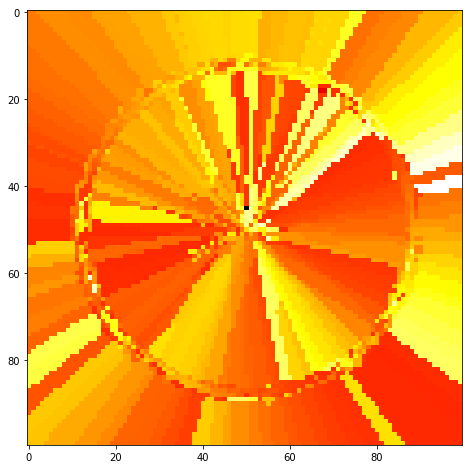

In [73]:
plt.imshow(quad_transform_grid_unraveled[:,:,0], cmap='hot', interpolation='nearest', extent=[-1,1,-1,1])
#plt.scatter(x,y, c=cmap(clf.predict(lm_params)), linewidths=1, edgecolors='k')

plt.show()

In [78]:
circle_transform_grid = circle_models.transform(xx,k=12)
pred = circle_km.predict(circle_transform_grid[:,2:])

In [79]:
circle_transform_grid_unraveled = circle_transform_grid.reshape((100,100,-1))

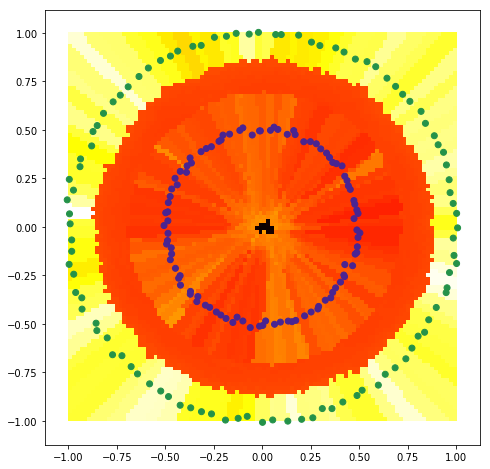

In [82]:
plt.imshow(circle_transform_grid_unraveled[:,:,2], cmap='hot', interpolation='nearest', extent=[-1,1,-1,1])
plt.scatter(noisy_circles[:,0], noisy_circles[:,1],c=cmap(c))
plt.show()

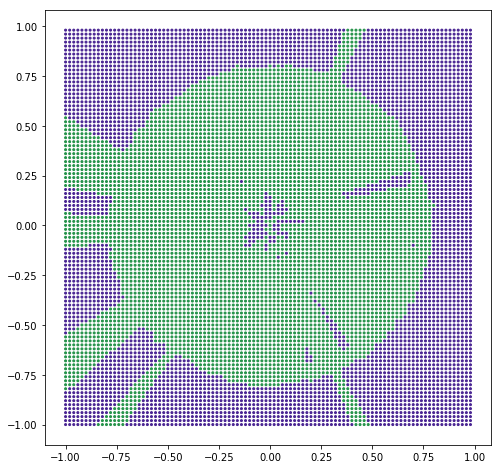

In [51]:
plt.scatter(xx[:,0], xx[:,1], c=cmap(pred), s=4)
#plt.scatter(x,y, c=cmap(clf.predict(lm_params)), linewidths=1, edgecolors='k')

plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline

In [3]:
print(animation.writers.list())

['imagemagick_file', 'ffmpeg', 'imagemagick', 'ffmpeg_file', 'html']


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

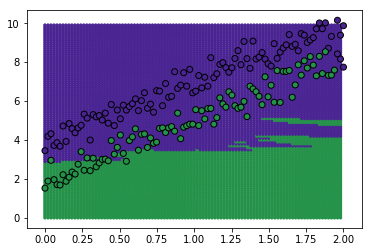

In [34]:
xdata, ydata = x, y
offsets = np.stack((xdata, ydata)).T
multioffsets = []
for i in range(100):
    offsets[:,1] += np.random.normal(0,0.05,offsets.shape[0])
    multioffsets.append(np.copy(offsets))

fig = plt.figure()
decision_surface = plt.scatter(xx[:,0], xx[:,1], c=cmap(pred), s=6, animated=True)
scat = plt.scatter(x,y, c=cmap(clf.predict(lm_params)), linewidths=1, edgecolors='k', animated=True)

def init():
    return scat, decision_surface

def update(frame):
    offsets = multioffsets[frame]
    models.fit(offsets[:,:1], offsets[:,1:], offsets)
    pred = clf.predict(models.transform(xx,k=k))
    decision_surface.set_color(cmap(pred))
    scat.set_offsets(np.copy(multioffsets[frame]))
    return scat, decision_surface


ani = FuncAnimation(fig, update, frames=range(100),
                    init_func=init, blit=True)

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='CScott!'), bitrate=1800)
ani.save('ani_k10_double.mp4', writer=writer)

HTML(ani.to_html5_video())
#offsets[:,1] += np.random.normal(0,0.05,offsets.shape[0])
#scat.set_offsets(offsets)
#scat